В датасете стоит задача определения воздушных рейсов, которые задержат свой вылет, что выжно для устойчивости логистических цепочек и избежания опасных ситуаций. Данные содержат информацию про самолет(количество мест, срок службы, компания владелец), погоду(общее количество осадков, количество выпавшего снега, количество снега, который выпадет за день, максимальную температуру в течение дня, максимальная скорость ветра в течение дня), информацию об аэропорте(название, широта и долгота, среднее количество вылетов в месяц)

Чтение данных и приведение категориальных признаков к числовым значениям

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score, cross_validate
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from reservoirpy.nodes import Reservoir, Ridge



In [2]:
data = pd.read_csv('data/full_data_flightdelay.csv')
data


,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.080,-115.152,NONE,0.00,0.0,0.0,65.0,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489057,12,7,0,2300-2359,1,11,3,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489058,12,7,0,1800-1859,1,11,2,123,Hawaiian Airlines Inc.,1318,...,16,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489059,12,7,0,2000-2059,1,11,2,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21
6489060,12,7,0,2100-2159,1,12,3,123,Hawaiian Airlines Inc.,1318,...,18,Lihue Airport,21.979,-159.346,Honolulu International,0.06,0.0,0.0,84.0,15.21


In [3]:
df = data.copy()

In [4]:
carriers = df['CARRIER_NAME'].value_counts()
carriers = carriers.index.values.tolist()
df['CARRIER_NAME'] = df['CARRIER_NAME'].replace(carriers, range(len(carriers)))

In [5]:
deps = df['DEP_TIME_BLK'].value_counts()
deps = deps.index.values.tolist()
df['DEP_TIME_BLK'] = df['DEP_TIME_BLK'].replace(deps, range(len(deps)))

In [6]:
airport = df['DEPARTING_AIRPORT'].value_counts()
airport = airport.index.values.tolist()
df['DEPARTING_AIRPORT'] = df['DEPARTING_AIRPORT'].replace(airport, range(len(airport)))

In [7]:
prev_airport = df['PREVIOUS_AIRPORT'].value_counts()
prev_airport = prev_airport.index.values.tolist()
df['PREVIOUS_AIRPORT'] = df['PREVIOUS_AIRPORT'].replace(prev_airport, range(len(prev_airport)))

In [8]:
df.dtypes

MONTH                              int64
DAY_OF_WEEK                        int64
DEP_DEL15                          int64
DEP_TIME_BLK                       int64
DISTANCE_GROUP                     int64
SEGMENT_NUMBER                     int64
CONCURRENT_FLIGHTS                 int64
NUMBER_OF_SEATS                    int64
CARRIER_NAME                       int64
AIRPORT_FLIGHTS_MONTH              int64
AIRLINE_FLIGHTS_MONTH              int64
AIRLINE_AIRPORT_FLIGHTS_MONTH      int64
AVG_MONTHLY_PASS_AIRPORT           int64
AVG_MONTHLY_PASS_AIRLINE           int64
FLT_ATTENDANTS_PER_PASS          float64
GROUND_SERV_PER_PASS             float64
PLANE_AGE                          int64
DEPARTING_AIRPORT                  int64
LATITUDE                         float64
LONGITUDE                        float64
PREVIOUS_AIRPORT                   int64
PRCP                             float64
SNOW                             float64
SNWD                             float64
TMAX            

In [9]:
tdf = df.copy()

Оценка корреляции данных 

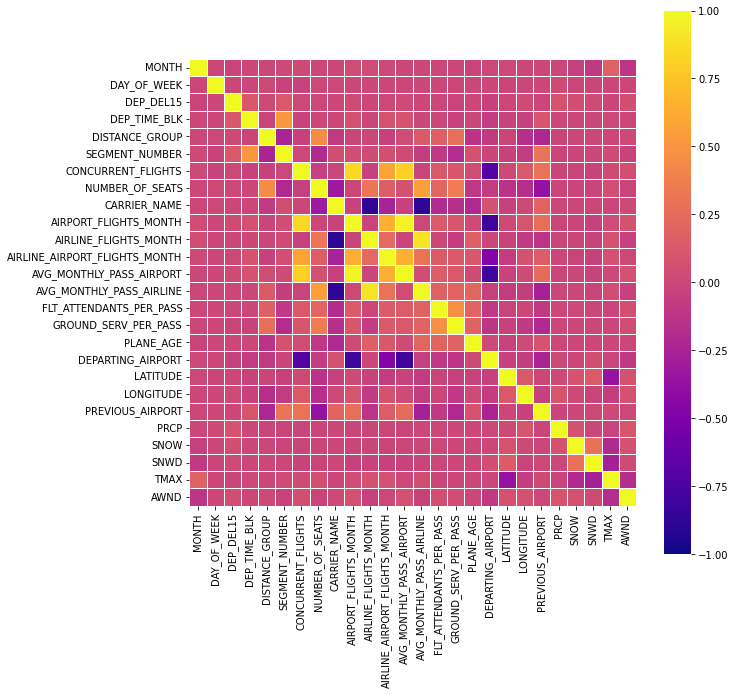

In [10]:
fig, ax = plt.subplots(figsize=(10,10))

corr_mat = df.corr()
sns.heatmap(corr_mat, square=True, cmap='plasma', linewidths=.5, ax=ax, vmin = -1, vmax = 1)
pass

In [14]:
corr_mat['DEP_DEL15']

MONTH                           -0.019049
DAY_OF_WEEK                     -0.000199
DEP_DEL15                        1.000000
DEP_TIME_BLK                     0.109707
DISTANCE_GROUP                   0.016289
SEGMENT_NUMBER                   0.117528
CONCURRENT_FLIGHTS               0.009028
NUMBER_OF_SEATS                  0.011845
CARRIER_NAME                     0.002282
AIRPORT_FLIGHTS_MONTH            0.026740
AIRLINE_FLIGHTS_MONTH            0.003528
AIRLINE_AIRPORT_FLIGHTS_MONTH    0.013711
AVG_MONTHLY_PASS_AIRPORT         0.024383
AVG_MONTHLY_PASS_AIRLINE         0.001257
FLT_ATTENDANTS_PER_PASS         -0.002114
GROUND_SERV_PER_PASS            -0.016736
PLANE_AGE                        0.006220
DEPARTING_AIRPORT               -0.037350
LATITUDE                         0.000490
LONGITUDE                        0.027097
PREVIOUS_AIRPORT                 0.001224
PRCP                             0.080277
SNOW                             0.050156
SNWD                             0

Избавляемся от данных, зависимость от которых мала

In [15]:
df = df.drop(['DAY_OF_WEEK', 'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS', 'PLANE_AGE', 'LATITUDE', 'TMAX', 'CONCURRENT_FLIGHTS', 'PREVIOUS_AIRPORT'], axis = 1)
df

,MONTH,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,GROUND_SERV_PER_PASS,DEPARTING_AIRPORT,LONGITUDE,PRCP,SNOW,SNWD,AWND
0,1,0,0,2,1,143,13056,5873,1903352,0.000099,10,-115.152,0.00,0.0,0.0,2.91
1,1,0,1,7,1,191,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
2,1,0,2,7,1,199,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
3,1,0,2,9,1,180,13056,1174,1903352,0.000149,10,-115.152,0.00,0.0,0.0,2.91
4,1,0,17,7,1,182,13056,1257,1903352,0.000125,10,-115.152,0.00,0.0,0.0,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489057,12,0,18,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489058,12,0,10,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489059,12,0,14,1,11,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21
6489060,12,0,15,1,12,123,1318,757,133573,0.000198,86,-159.346,0.06,0.0,0.0,15.21


Больше всего самолетов отменяют в июне(относительно общего числа полетов)

In [16]:
# pd.crosstab(data.MONTH, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
# plt.title('Departure Delays in MONTH')
# plt.xlabel('MONTH')
# plt.ylabel('Departure Delays')

In [17]:
# pd.crosstab(data.DISTANCE_GROUP, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
# plt.title('Departure Delays in DISTANCE_GROUP')
# plt.xlabel('DISTANCE_GROUP')
# plt.ylabel('Departure Delays')

In [18]:
# pd.crosstab(data.SEGMENT_NUMBER, data.DEP_DEL15, normalize='index' ).plot(kind='bar')
# plt.title('Departure Delays in SEGMENT_NUMBER')
# plt.xlabel('SEGMENT_NUMBER')
# plt.ylabel('Departure Delays')

Сбалансируем классы, для чего возьмем количество записей равное наименьшему классу для каждого из классов

In [19]:
c2 = df[df['DEP_DEL15'] == 1]
c1 = df[df['DEP_DEL15'] == 0]
req = int(min(c2.size, c1.size) / 16)
df_2 = c2.sample(req)
df_1 = c1.sample(req)
df = pd.concat([df_2,df_1],axis=0)

In [20]:
X = df.drop('DEP_DEL15', axis = 1)
y = df['DEP_DEL15']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=17)

In [22]:
X_train

,MONTH,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,GROUND_SERV_PER_PASS,DEPARTING_AIRPORT,LONGITUDE,PRCP,SNOW,SNWD,AWND
4687991,9,9,2,3,76,2024,301,220025,0.000099,63,-106.606,0.00,0.0,0.0,6.04
2708923,6,5,4,3,140,25390,12632,2907365,0.000177,2,-97.030,0.00,0.0,0.0,3.36
1608219,4,15,2,2,76,13675,3299,1908862,0.000099,8,-122.375,0.00,0.0,0.0,12.53
5919440,11,3,6,1,175,4718,4348,589072,0.000099,35,-95.279,0.00,0.0,0.0,5.14
4964836,10,5,3,1,76,20449,227,2006675,0.000094,4,-80.936,0.29,0.0,0.0,8.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3154029,6,8,2,4,129,1427,220,106734,0.000108,89,-78.930,0.00,0.0,0.0,11.63
1636388,4,7,2,3,50,26142,4835,3103410,0.000099,1,-87.906,0.25,0.0,0.0,9.84
896280,2,3,1,5,143,11500,5104,1903352,0.000099,10,-115.152,0.01,0.0,0.0,13.20
3699350,7,17,7,1,181,13781,769,1960746,0.000177,14,-122.306,0.00,0.0,0.0,6.71


Классификация с помощью метода k-nearest neighbors

In [23]:
# neighbors = np.arange(1,7)
# train = []
# test = []
# for i,k in enumerate(neighbors):
#     knn = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=k, n_jobs=-1))])
#     knn.fit(X_train, y_train)
#     train.append(knn.score(X_train, y_train))
#     test.append(knn.score(X_test, y_test))
#     print(f'{k} done')

In [24]:
# plt.plot(np.arange(1,7), train)
# plt.plot(np.arange(1,7), test)
# max(test)

In [25]:
knn = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=6, n_jobs=-1))])
knn.fit(X_train, y_train)
predict = knn.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.74      0.59      0.66    456923
       Delay       0.50      0.65      0.56    279498

    accuracy                           0.62    736421
   macro avg       0.62      0.62      0.61    736421
weighted avg       0.65      0.62      0.62    736421



<function matplotlib.pyplot.show(close=None, block=None)>

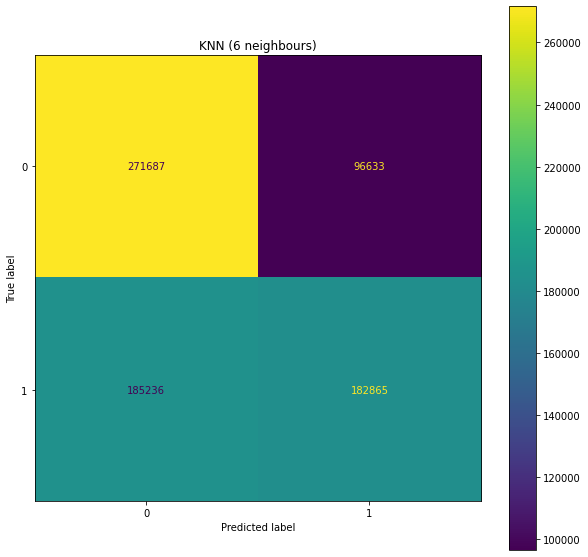

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'KNN (6 neighbours)')
ConfusionMatrixDisplay.from_estimator(knn, X_test,y_test, ax=ax)  
plt.show

Классификация с помощью логистической регрессии

In [28]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.06      0.51      0.11     46235
       Delay       0.94      0.50      0.65    690186

    accuracy                           0.50    736421
   macro avg       0.50      0.51      0.38    736421
weighted avg       0.88      0.50      0.62    736421



<function matplotlib.pyplot.show(close=None, block=None)>

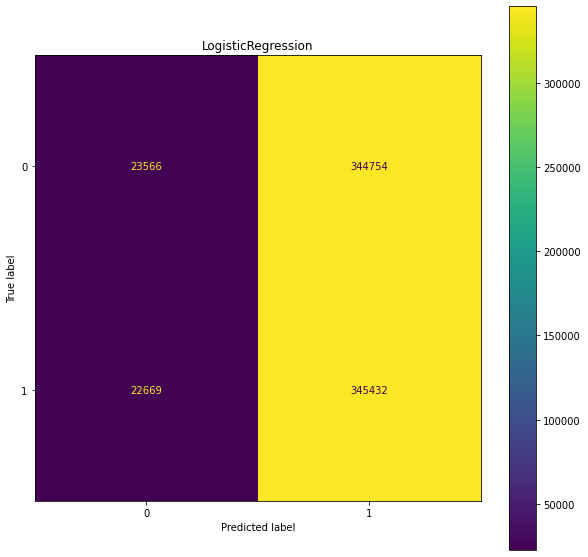

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

Классификация на полных данных, по наиболее каррелируемым признакам

In [30]:
X = tdf[["TMAX","PRCP","SNOW","CARRIER_NAME","SNWD","AWND","CONCURRENT_FLIGHTS","DEP_TIME_BLK","DEPARTING_AIRPORT","FLT_ATTENDANTS_PER_PASS","NUMBER_OF_SEATS"]] #"TMAX","CARRIER_NAME","CONCURRENT_FLIGHTS","FLT_ATTENDANTS_PER_PASS"
y = tdf["DEP_DEL15"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=21)

In [31]:
model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [32]:
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       1.00      0.81      0.90   1291694
       Delay       0.01      0.45      0.02      6119

    accuracy                           0.81   1297813
   macro avg       0.50      0.63      0.46   1297813
weighted avg       0.99      0.81      0.89   1297813



<function matplotlib.pyplot.show(close=None, block=None)>

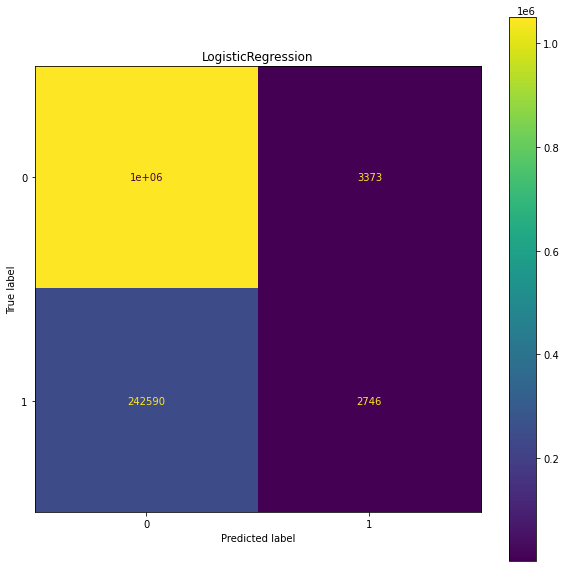

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

In [34]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

c:\Users\dimar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

   Not Delay       0.59      0.85      0.70    725887
       Delay       0.57      0.24      0.34    571926

    accuracy                           0.58   1297813
   macro avg       0.58      0.55      0.52   1297813
weighted avg       0.58      0.58      0.54   1297813



<function matplotlib.pyplot.show(close=None, block=None)>

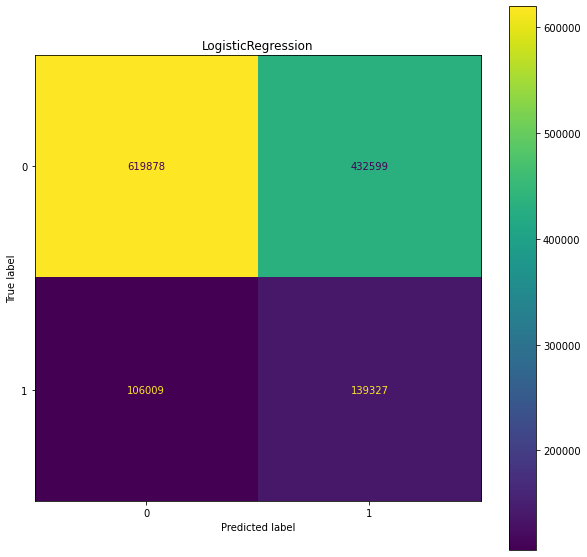

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

In [36]:
knn = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=6, n_jobs=-1))])
knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=6))])

In [37]:
predict = knn.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.97      0.83      0.89   1232490
       Delay       0.14      0.52      0.22     65323

    accuracy                           0.81   1297813
   macro avg       0.55      0.67      0.56   1297813
weighted avg       0.93      0.81      0.86   1297813



<function matplotlib.pyplot.show(close=None, block=None)>

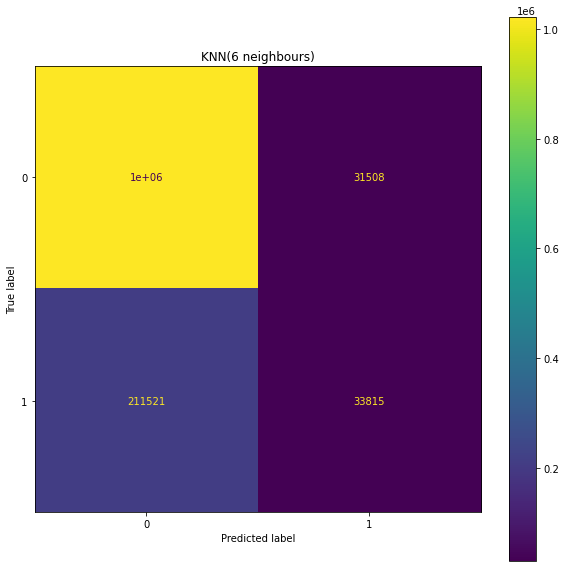

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'KNN(6 neighbours)')
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, ax=ax)  
plt.show

Стандартизация и нормализация данных:

Избавляемся от выбросов

In [11]:
tdf_f = tdf.drop(['DAY_OF_WEEK', 'CARRIER_NAME', 'AIRLINE_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS', 'PLANE_AGE', 'LATITUDE', 'TMAX', 'CONCURRENT_FLIGHTS', 'PREVIOUS_AIRPORT'], axis = 1)

In [12]:
ncols = np.clip(len(tdf_f.columns), 0, 16)
cols = tdf_f.columns[:ncols]
drop = (tdf_f[cols[0]] < tdf_f[cols[0]].quantile(0.005)) | (tdf_f[cols[0]] > tdf_f[cols[0]].quantile(0.995))
for i in range(1, ncols):
    drop = drop | (tdf_f[cols[i]] < tdf_f[cols[i]].quantile(0.005)) | (tdf_f[cols[i]] > tdf_f[cols[i]].quantile(0.995))
rtd = tdf_f[drop].index
df_clear = tdf_f.drop(index = rtd)

In [13]:
c2 = df_clear[df_clear['DEP_DEL15'] == 1]
c1 = df_clear[df_clear['DEP_DEL15'] == 0]
req = int(min(c2.size, c1.size) / 16)
df_2 = c2.sample(req)
df_1 = c1.sample(req)
df_clear = pd.concat([df_2,df_1],axis=0)

Нормализация

In [14]:
X = df_clear.drop('DEP_DEL15', axis = 1)
y = df_clear['DEP_DEL15']
transformer = Normalizer().fit(X)
X_normalize = transformer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalize,y, test_size=0.3, random_state=17)

In [43]:
# neighbors = np.arange(1,7)
# train = []
# test = []
# for i,k in enumerate(neighbors):
#     knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
#     knn.fit(X_train, y_train)
#     train.append(knn.score(X_train, y_train))
#     test.append(knn.score(X_test, y_test))
#     print(f'{k} done')

In [44]:
# plt.plot(np.arange(1,7), train)
# plt.plot(np.arange(1,7), test)
# max(test)

In [45]:
knn = KNeighborsClassifier(n_neighbors=6, n_jobs=-1)
knn.fit(X_train, y_train)
predict = knn.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.73      0.59      0.65    428424
       Delay       0.49      0.64      0.55    263997

    accuracy                           0.61    692421
   macro avg       0.61      0.61      0.60    692421
weighted avg       0.63      0.61      0.61    692421



<function matplotlib.pyplot.show(close=None, block=None)>

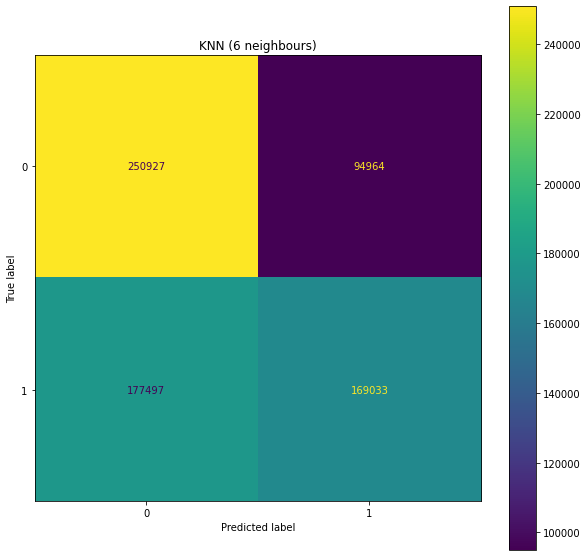

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'KNN (6 neighbours)')
ConfusionMatrixDisplay.from_estimator(knn, X_test,y_test, ax=ax)  
plt.show

In [47]:
model = LogisticRegression(class_weight='balanced', solver='newton-cholesky')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.56      0.51      0.53    382272
       Delay       0.46      0.51      0.48    310149

    accuracy                           0.51    692421
   macro avg       0.51      0.51      0.51    692421
weighted avg       0.52      0.51      0.51    692421



<function matplotlib.pyplot.show(close=None, block=None)>

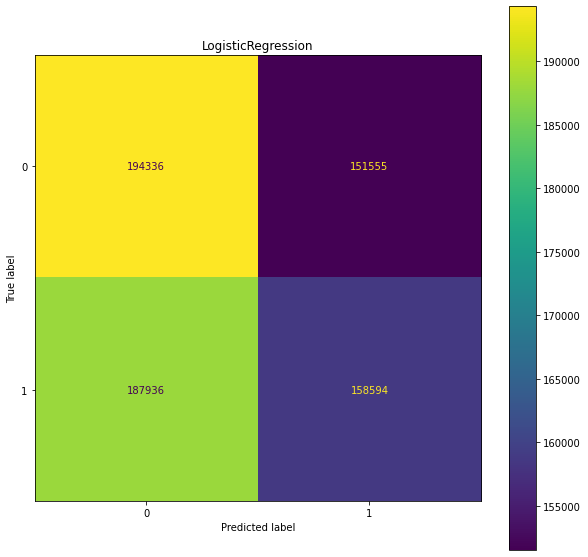

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

Стандартизация данных

In [15]:
transformer = StandardScaler().fit(X)
X_Sscaler = transformer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_Sscaler,y, test_size=0.3, random_state=17)

In [50]:
# neighbors = np.arange(1,7)
# train = []
# test = []
# for i,k in enumerate(neighbors):
#     knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
#     knn.fit(X_train, y_train)
#     train.append(knn.score(X_train, y_train))
#     test.append(knn.score(X_test, y_test))
#     print(f'{k} done')

In [51]:
# plt.plot(np.arange(1,7), train)
# plt.plot(np.arange(1,7), test)
# max(test)

In [52]:
knn = KNeighborsClassifier(n_neighbors=6, n_jobs=-1)
knn.fit(X_train, y_train)
predict = knn.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.73      0.59      0.66    429533
       Delay       0.49      0.65      0.56    262888

    accuracy                           0.61    692421
   macro avg       0.61      0.62      0.61    692421
weighted avg       0.64      0.61      0.62    692421



<function matplotlib.pyplot.show(close=None, block=None)>

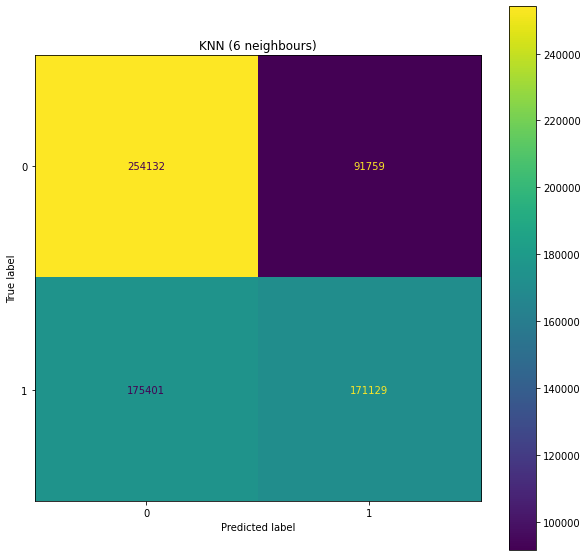

In [53]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'KNN (6 neighbours)')
ConfusionMatrixDisplay.from_estimator(knn, X_test,y_test, ax=ax)  
plt.show

In [54]:
model = LogisticRegression(class_weight='balanced', solver= 'newton-cholesky')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.61      0.59      0.60    359991
       Delay       0.57      0.60      0.58    332430

    accuracy                           0.59    692421
   macro avg       0.59      0.59      0.59    692421
weighted avg       0.59      0.59      0.59    692421



<function matplotlib.pyplot.show(close=None, block=None)>

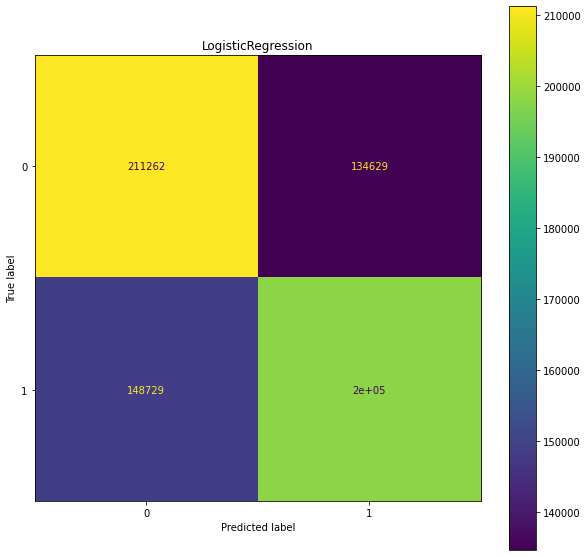

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

MinMaxScaler

In [16]:
transformer = MinMaxScaler().fit(X)
X_MMscaler = transformer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_MMscaler,y, test_size=0.3, random_state=17)

In [57]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.61      0.59      0.60    359985
       Delay       0.57      0.60      0.58    332436

    accuracy                           0.59    692421
   macro avg       0.59      0.59      0.59    692421
weighted avg       0.59      0.59      0.59    692421



<function matplotlib.pyplot.show(close=None, block=None)>

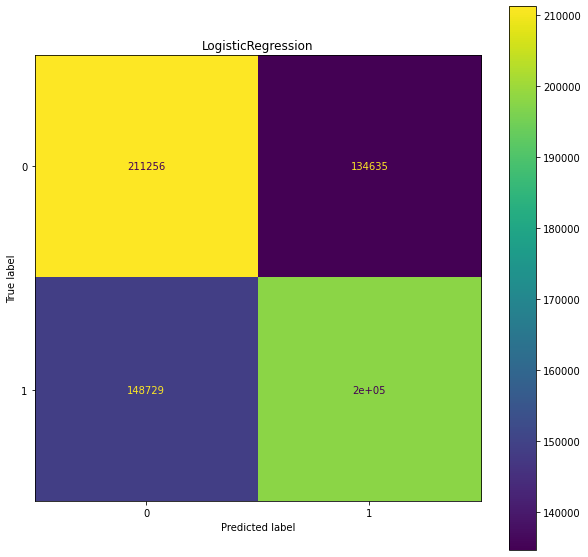

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

MaxAbsScaler

In [17]:
transformer = MaxAbsScaler().fit(X)
X_MAscaler = transformer.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_MAscaler,y, test_size=0.3, random_state=17)

In [60]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
predict = model.predict(X_test)
target_names = ['Not Delay', 'Delay']
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.61      0.59      0.60    359974
       Delay       0.57      0.60      0.58    332447

    accuracy                           0.59    692421
   macro avg       0.59      0.59      0.59    692421
weighted avg       0.59      0.59      0.59    692421



<function matplotlib.pyplot.show(close=None, block=None)>

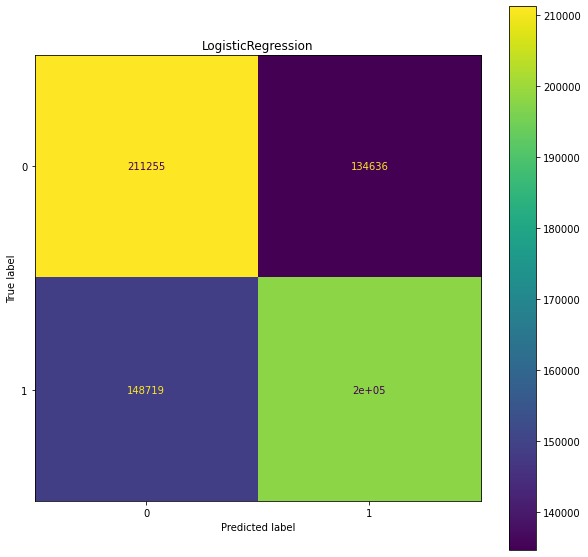

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'LogisticRegression')
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)  
plt.show

In [62]:
#MLPClassifier()
# train = []
# test = []
# layers = np.arange(15, 101, 5)
# for k in layers:
#     clf = MLPClassifier(hidden_layer_sizes = (k, ), random_state=17, max_iter=500)
#     clf.fit(X_train, y_train)
#     train.append(clf.score(X_train, y_train))
#     test.append(clf.score(X_test, y_test))
#     print(f'{k} done')

In [63]:
# plt.plot(layers, train)
# plt.plot(layers, test)
# max(test)

In [64]:
#[[i, j, k, l] for i in range(30, 51, 20) for j in range(30, 51, 20) for k in range(30, 51, 20) for l in range(30, 51, 20)]

Нормализованные данные

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_normalize, y, test_size=0.3, random_state=17)

In [66]:
MLPclass = MLPClassifier()
layers = [[i] for i in range(10, 31, 10)]+[[i, j] for i in range(10, 31, 10) for j in range(10, 31, 10)]
parameters = {'hidden_layer_sizes': layers}
clf = GridSearchCV(MLPclass, parameters, n_jobs = -1)
report = clf.fit(X_train, y_train)

In [67]:
target_names = ['Not Delay', 'Delay']
predict = clf.best_estimator_.predict(X_test)
print(classification_report(predict, y_test, target_names=target_names))

              precision    recall  f1-score   support

   Not Delay       0.87      0.51      0.64    592799
       Delay       0.15      0.53      0.24     99622

    accuracy                           0.51    692421
   macro avg       0.51      0.52      0.44    692421
weighted avg       0.76      0.51      0.58    692421



<function matplotlib.pyplot.show(close=None, block=None)>

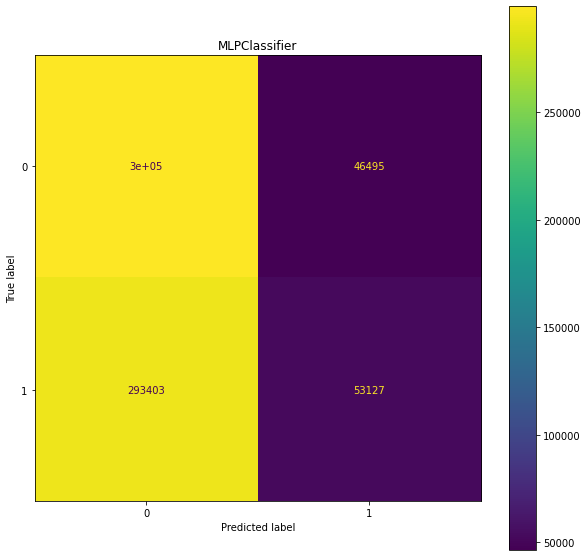

In [68]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'MLPClassifier')
ConfusionMatrixDisplay.from_estimator(clf.best_estimator_, X_test, y_test, ax=ax)  
plt.show

In [69]:
clf.best_estimator_

MLPClassifier(hidden_layer_sizes=[20, 20])

In [20]:
train_states.shape

(1615649, 100)

In [19]:
reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

train_states = reservoir.run(X_train, reset = True)
readout = ridge.fit(train_states, np.array(y_train), warmup = 10)
test_states = reservoir.run(X_test)
predict = readout.run(test_states)
print(classification_report(predict, y_test, target_names=target_names))

Running Reservoir-0: 100%|██████████| 1615649/1615649 [01:50<00:00, 14560.04it/s]


ValueError: shapes (1615649,0) and (1615639,101) not aligned: 0 (dim 1) != 1615639 (dim 0)

In [72]:
esn_model = reservoir >> ridge
esn_model = esn_model.fit(X_train, y_train, warmup=10)
predict = esn_model.run(X_test)
print(classification_report(predict, y_test, target_names=target_names))

ValueError: Missing target data for node Ridge-1.

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'ESN')
ConfusionMatrixDisplay.from_estimator(esn_model, X_test, y_test, ax=ax)  
plt.show

In [ ]:
reservoir = Reservoir(1000, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = reservoir >> ridge

esn_model = esn_model.fit(X_train, y_train, warmup=10)
predict = esn_model.run(X_test)
print(classification_report(predict, y_test, target_names=target_names))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'ESN')
ConfusionMatrixDisplay.from_estimator(esn_model, X_test, y_test, ax=ax)  
plt.show

In [ ]:
neurons = np.arange(100, 5000, 100)
train = []
test = []
for i in neurons:
        reservoir = Reservoir(i, lr=0.5, sr=0.9)
        ridge = Ridge(ridge=1e-7)
        esn_model = reservoir >> ridge
        esn_model = esn_model.fit(X_train, y_train, warmup=10)
        predict = esn_model.run(X_test)
        train.append(clf.score(X_train, y_train))
        test.append(clf.score(X_test, y_test))
        print(f'{i} done')

In [ ]:
plt.plot(neurons, train)
plt.plot(neurons, test)

In [ ]:
max_acc = max(test)
max_neurons = test.index(max_acc)
train = []
test = []
lr = np.arange(0, 1, 0.05)
for i in lr:
    reservoir = Reservoir(max_neurons, lr = i, sr=0.9)
    ridge = Ridge(ridge=1e-7)
    esn_model = reservoir >> ridge
    esn_model = esn_model.fit(X_train, y_train, warmup=10)
    predict = esn_model.run(X_test)
    train.append(clf.score(X_train, y_train))
    test.append(clf.score(X_test, y_test))
    print(f'{i} done')

In [ ]:
plt.plot(lr, train)
plt.plot(lr, test)

Стандартизированные данные

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_Sscaler,y, test_size=0.3, random_state=17)

In [ ]:
reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = reservoir >> ridge

esn_model = esn_model.fit(X_train, y_train, warmup=10)
predict = esn_model.run(X_test)
print(classification_report(predict, y_test, target_names=target_names))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'ESN')
ConfusionMatrixDisplay.from_estimator(esn_model, X_test, y_test, ax=ax)  
plt.show

In [ ]:
reservoir = Reservoir(1000, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = reservoir >> ridge

esn_model = esn_model.fit(X_train, y_train, warmup=10)
predict = esn_model.run(X_test)
print(classification_report(predict, y_test, target_names=target_names))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title(f'ESN')
ConfusionMatrixDisplay.from_estimator(esn_model, X_test, y_test, ax=ax)  
plt.show

In [ ]:
neurons = np.arange(100, 5000, 100)
train = []
test = []
for i in neurons:
        reservoir = Reservoir(i, lr=0.5, sr=0.9)
        ridge = Ridge(ridge=1e-7)
        esn_model = reservoir >> ridge
        esn_model = esn_model.fit(X_train, y_train, warmup=10)
        predict = esn_model.run(X_test)
        train.append(clf.score(X_train, y_train))
        test.append(clf.score(X_test, y_test))
        print(f'{i} done')

In [ ]:
plt.plot(neurons, train)
plt.plot(neurons, test)

In [ ]:
max_acc = max(test)
max_neurons = test.index(max_acc)
lr = np.arange(0, 1, 0.05)
train = []
test = []
for i in lr:
    reservoir = Reservoir(max_neurons, lr = i, sr=0.9)
    ridge = Ridge(ridge=1e-7)
    esn_model = reservoir >> ridge
    esn_model = esn_model.fit(X_train, y_train, warmup=10)
    predict = esn_model.run(X_test)
    train.append(clf.score(X_train, y_train))
    test.append(clf.score(X_test, y_test))
    print(f'{i} done')

In [ ]:
plt.plot(lr, train)
plt.plot(lr, test)